In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.integrate import dblquad, tplquad
from getdist import plots, MCSamples
import getdist
import torch 
import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# Models 

$$\mathcal{M}_{0}: y = A \sin(wx)$$

$$\mathcal{M}_{1}: y= ax^{2}+bx$$

$\mathcal{M}_{0}$ is not nested in $\mathcal{M}_{1}$. 

**Steps**

- Generate data using $\mathcal{M}_{0}$.
- Compute evidence analytically. 
- Compute evidence numerically. 
- Compute Bayes Factor. 
- Repeat 2-4 with the compression scheme. 

In [2]:
def model_0(xvalues: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    
    output = parameters[0]*xvalues**2 + parameters[1]*xvalues
    output = output.to(torch.float64)
    return output

def model_1(xvalues: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    
    output = parameters[0]*xvalues**2 + parameters[1]*xvalues + parameters[2]
    output = output.to(torch.float64)
    return output

In [3]:
def Z0(Y1: torch.Tensor, design_0: torch.Tensor, B1: torch.Tensor, \
       Lambda1: torch.Tensor, Sigma0: torch.Tensor, \
       mustar_0: torch.Tensor, mustar_1: torch.Tensor) -> torch.Tensor:
    
    Z0debug = False
    
    Ybarstar  = B1.t() @ (mustar_0-mustar_1)

    Psi = Lambda1+B1.t() @ design_0 @ Sigma0 @ design_0.t() @ B1
    ZZ_pdf_Psi = torch.distributions.multivariate_normal.MultivariateNormal \
    (Ybarstar, Psi)
    
    logZ0 = ZZ_pdf_Psi.log_prob(Y1).item()

    if(Z0debug):

#        print('Lambda1:',Lambda1)
#        print('Psi:',Psi)
        print('Y1:',Y1)
#        print('Ybarstar:',Ybarstar)
#        print('B1:',B1)
#        print('Sigma0:',Sigma0)
#        print('design_0:',design_0)
    
        print(-0.5*np.log(np.linalg.det(2.*np.pi*Psi)))
        print('logZ0 (new):',logZ0)

    return logZ0

In [4]:
xmin = 0.1
xmax = torch.pi
ndata = 10
xvals = torch.linspace(xmin, xmax, ndata)

# True parameters:

a_param = -1.0
b_param = 4.0
c_param = 1.0

# Fiducial parameters:
 
a_fid = -1.0
b_fid = 4.0
c_fid = 0.0

# model 0
m0_parameters = torch.tensor([a_param, b_param])
m0_function = model_0(xvals, m0_parameters)

# model 1
m1_parameters = torch.tensor([a_param, b_param, c_param])
m1_function = model_1(xvals, m1_parameters)

# Error and prior width:

sigma = 0.5
priorWidth = 1.0

# Fiducial mean:

fid_0_parameters = torch.tensor([a_fid, b_fid])
fid_1_parameters = torch.tensor([a_fid, b_fid, c_fid])
mustar_0 = model_0(xvals, fid_0_parameters)
mustar_1 = model_1(xvals, fid_1_parameters)

debug = False

u = '_'
fileroot='Results/Nested_'+str(round(a_param*10))+\
    u+str(round(b_param*10))+u+str(round(c_param*10))+u+str(round(a_fid*10))+u+str(round(b_fid*10))+\
    u+str(round(c_fid*10))+u+str(round(sigma*10))+u+str(round(priorWidth*10))+u+str(ndata)

print(fileroot)

Results/Nested_-10_40_10_-10_40_0_5_10_10


# Data
The data is generated using Model trueModel.

In [5]:
trueModel = 1

if(trueModel==0):
    dataTrue = model_0(xvals, m0_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
    dataTrue = dataTrue.type(torch.float64)
else:
    dataTrue = model_1(xvals, m1_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
    dataTrue = dataTrue.type(torch.float64)
    
X = dataTrue-mustar_1

print(X)
print(dataTrue)

tensor([ 1.6069,  0.5119,  1.3168,  1.1113,  0.2311,  0.9578, -0.1380,  2.2813,
         1.6527,  1.3425], dtype=torch.float64)
tensor([1.9969, 2.0719, 3.8184, 4.3261, 3.9306, 4.9136, 3.8457, 6.0644, 5.0068,
        4.0393], dtype=torch.float64)


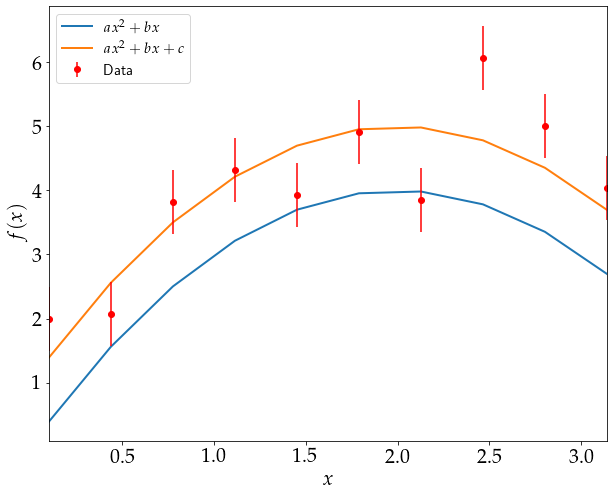

In [6]:
plt.figure(figsize = (10, 8))
plt.plot(xvals, m0_function, lw = 2, label = r'$ax^{2} + bx$')
plt.plot(xvals, m1_function, lw = 2, label = r'$ax^{2} + bx+c$')
plt.errorbar(xvals, dataTrue, yerr = sigma, fmt = 'ro', label = 'Data')
plt.xlim(xmin, xmax)
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Define all quantities 

In [7]:
C = torch.from_numpy(np.diag([sigma**2] * ndata))
C_inv = torch.from_numpy(np.diag([1/sigma**2] * ndata))

In [8]:
design_0 = torch.zeros((ndata, 2), dtype = float)
design_0[:,0] = xvals**2
design_0[:,1] = xvals

design_1 = torch.zeros((ndata, 3), dtype = float)
design_1[:,0] = xvals**2
design_1[:,1] = xvals
design_1[:,2] = 1

In [9]:
print(design_0)

tensor([[0.0100, 0.1000],
        [0.1918, 0.4380],
        [0.6020, 0.7759],
        [1.2407, 1.1139],
        [2.1078, 1.4518],
        [3.2033, 1.7898],
        [4.5272, 2.1277],
        [6.0796, 2.4657],
        [7.8604, 2.8036],
        [9.8696, 3.1416]], dtype=torch.float64)


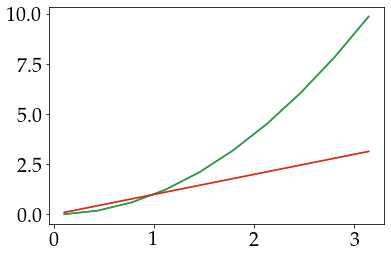

In [10]:
plt.plot(xvals,design_0[:,0])
plt.plot(xvals,design_0[:,1])
plt.plot(xvals,design_1[:,0])
plt.plot(xvals,design_1[:,1])

# Define the priors

We are assuming independent normal distribution. Multivariate normal distribution with the identity matrix as covariance. 

In [11]:
theta_fid_0 = torch.tensor([a_fid, b_fid], dtype = float)
theta_fid_1 = torch.tensor([a_fid, b_fid, c_fid], dtype = float)

Sigma0 = priorWidth * torch.eye(2, dtype = float)
Sigma1 = priorWidth * torch.eye(3, dtype = float)

Sigma0_inv = torch.linalg.inv(Sigma0)
Sigma1_inv = torch.linalg.inv(Sigma1)

# Evidence Computation

$$ Z(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu},\,\mathbf{C}+\boldsymbol{\Phi}\boldsymbol{\Sigma}\boldsymbol{\Phi}^{\textrm{T}})$$

In [12]:
G0 = C + design_0 @ Sigma0 @ design_0.t()
G1 = C + design_1 @ Sigma1 @ design_1.t()

In [13]:
zero = torch.zeros(ndata)

X_pdf0 = torch.distributions.multivariate_normal.MultivariateNormal(mustar_0, G0)
X_pdf1 = torch.distributions.multivariate_normal.MultivariateNormal(mustar_1, G1)

In [14]:
ZX0 = X_pdf0.log_prob(dataTrue).item()
ZX1 = X_pdf1.log_prob(dataTrue).item()

In [15]:
print(f'The log-evidence of Model 0 is {ZX0:.4f}')
print(f'The log-evidence of Model 1 is {ZX1:.4f}')
print(f'The log-Bayes Factor between Model 0 and 1 is {ZX0 - ZX1:.4f}')

The log-evidence of Model 0 is -19.9309
The log-evidence of Model 1 is -16.3030
The log-Bayes Factor between Model 0 and 1 is -3.6280


# Compression

In [16]:
# calculate the MOPED vectors (gradient is analytical)

B0 = C_inv @ design_0
B1 = C_inv @ design_1

In [17]:
# calculate the compressed data vectors 

Y1 = B1.t() @ (dataTrue-mustar_1)

print(Y1.numpy())

[181.30410301  75.50645505  43.49737659]


# Analytical Evidence

In [18]:
Yzero1 = 0.0*Y1

In [19]:
Lambda1 = design_1.t() @ C_inv @ design_1

print(Lambda1)

Lambda1_inv = torch.linalg.inv(Lambda1)

tensor([[933.1779, 353.5776, 142.7697],
        [353.5776, 142.7697,  64.8319],
        [142.7697,  64.8319,  40.0000]], dtype=torch.float64)


In [20]:
Fisher = design_0.t() @ B1 @ Lambda1_inv @ B1.t() @ design_0
Fisher_inv = torch.linalg.inv(Fisher)

print('Fisher:',Fisher.numpy())
print('Errors:',np.sqrt(Fisher_inv[0,0]).numpy(),np.sqrt(Fisher_inv[1,1]).numpy())

Fisher: [[933.17791991 353.57755709]
 [353.57755709 142.76966083]]
Errors: 0.1318507947346826 0.3370908895443259


In [21]:
H1 = Lambda1+ (Lambda1 @ Sigma1 @ Lambda1.t() )
print(H1)
print(Lambda1)
print(Lambda1+B1.t() @ design_1 @ Sigma1 @ design_1.t() @ B1)
print(torch.linalg.det(Lambda1))
print(torch.linalg.det(H1))
print(torch.linalg.eig(H1))

tensor([[1017154.4731,  390040.5167,  162006.1401],
        [ 390040.5167,  149746.2040,   62394.2759],
        [ 162006.1401,   62394.2759,   26226.3455]], dtype=torch.float64)
tensor([[933.1779, 353.5776, 142.7697],
        [353.5776, 142.7697,  64.8319],
        [142.7697,  64.8319,  40.0000]], dtype=torch.float64)
tensor([[1017154.4731,  390040.5167,  162006.1401],
        [ 390040.5167,  149746.2040,   62394.2759],
        [ 162006.1401,   62394.2759,   26226.3455]], dtype=torch.float64)
tensor(41535.4754, dtype=torch.float64)
tensor(2.8791e+09, dtype=torch.float64)
torch.return_types.linalg_eig(
eigenvalues=tensor([1.1926e+06+0.j, 5.3881e+02+0.j, 4.4805e+00+0.j],
       dtype=torch.complex128),
eigenvectors=tensor([[-0.9235+0.j, -0.3076+0.j,  0.2292+0.j],
        [-0.3542+0.j,  0.4546+0.j, -0.8172+0.j],
        [-0.1472+0.j,  0.8359+0.j,  0.5288+0.j]], dtype=torch.complex128))


In [22]:
ZY_pdf1 = torch.distributions.multivariate_normal.MultivariateNormal(Yzero1, H1)

In [23]:
ZY1 = ZY_pdf1.log_prob(Y1).item()
ZY0 = Z0(Y1, design_0, B1, Lambda1, Sigma0, mustar_0, mustar_1)

print('ZY0:',ZY0)
print('ZY1:',ZY1)

ZY0: -18.39961203535278
ZY1: -14.771627133626446


In [24]:
if(debug):
    print('design_1:',design_1)

In [25]:
print(f'X log-evidence of Model 0 is {ZX0:.4f}')
print(f'X log-evidence of Model 1 is {ZX1:.4f}')
print(f'Y log-evidence of (true)  Model 0 is {ZY0:.4f}')
print(f'Y log-evidence of (false) Model 1 is {ZY1:.4f}')
print(f'X log-Bayes Factor between Model 0 and 1 is {ZX0 - ZX1:.4f}')
print(f'Y log-Bayes Factor between Model 0 and 1 is {ZY0 - ZY1:.4f}')
print(f'The difference is {ZY0-ZY1-ZX0+ZX1:.4f}')

X log-evidence of Model 0 is -19.9309
X log-evidence of Model 1 is -16.3030
Y log-evidence of (true)  Model 0 is -18.3996
Y log-evidence of (false) Model 1 is -14.7716
X log-Bayes Factor between Model 0 and 1 is -3.6280
Y log-Bayes Factor between Model 0 and 1 is -3.6280
The difference is -0.0000


In [26]:
print(Y1.numpy())
print(H1.numpy())
print(Lambda1.numpy())
print(Sigma1.numpy())

[181.30410301  75.50645505  43.49737659]
[[1017154.4730517   390040.51667599  162006.14013967]
 [ 390040.51667599  149746.20402886   62394.27591752]
 [ 162006.14013967   62394.27591752   26226.34548255]]
[[933.17791991 353.57755709 142.76966081]
 [353.57755709 142.76966083  64.83185509]
 [142.76966081  64.83185509  40.        ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [27]:
ntrials = 100000

Z0_X = np.zeros(ntrials)
Z1_X = np.zeros(ntrials)
Z0_Y = np.zeros(ntrials)
Z1_Y = np.zeros(ntrials)
Bayes_X = np.zeros(ntrials)
Bayes_Y = np.zeros(ntrials)
Bayes_diff = np.zeros(ntrials)

debug=False

for n in range(ntrials):
    if(trueModel==0):
        data = model_0(xvals, m0_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
        data = data.type(torch.float64)
    else:
        data = model_1(xvals, m1_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
        data = data.type(torch.float64)
        
    Z0_X[n]  = X_pdf0.log_prob(data).item()
    Z1_X[n]  = X_pdf1.log_prob(data).item()
    
    Bayes_X[n] = Z0_X[n]-Z1_X[n]
     
    Y1   = B1.t() @ (data-mustar_1)  

    Z0_Y[n]  = Z0(Y1, design_0, B1, Lambda1, Sigma0, mustar_0, mustar_1)
    Z1_Y[n]  = ZY_pdf1.log_prob(Y1).item()
    
    Bayes_Y[n] = Z0_Y[n]-Z1_Y[n]

    Bayes_diff[n] = Bayes_Y[n] - Bayes_X[n]
    
    if(debug):
        print('Y1=',Y1.numpy())
        print('ZY0=',Z0_Y[n])
        print('ZY1=',Z1_Y[n])
        print('BX=',Z0_X[n]-Z1_X[n])
        print('BY=',Z0_Y[n]-Z1_Y[n])

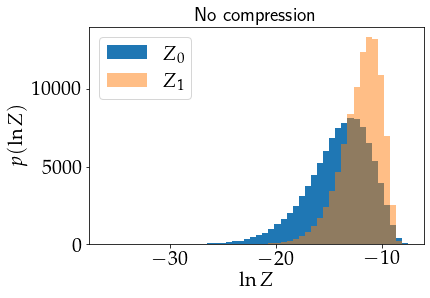

In [28]:
nbins = 50

plt.hist(Z0_X,bins=nbins, alpha=1, \
         range=[np.min([np.min(Z1_X),np.min(Z0_X)]), np.max([np.max(Z1_X),np.max(Z0_X)])]);
plt.hist(Z1_X,bins=nbins, alpha=0.5, \
         range=[np.min([np.min(Z1_X),np.min(Z0_X)]), np.max([np.max(Z1_X),np.max(Z0_X)])]);
plt.xlabel(r'$\ln Z$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.legend([r'$Z_0$',r'$Z_1$'], fontsize=20)
plt.title('No compression', fontsize=20)
plt.savefig(fileroot+'ZX01.pdf', bbox_inches='tight')

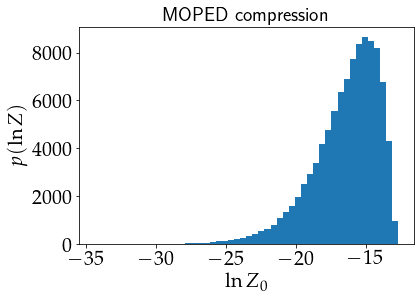

In [29]:
plt.hist(Z0_Y,bins=nbins, alpha=1, \
         range=[np.min(Z0_Y),np.max(Z0_Y)]);
plt.xlabel(r'$\ln Z_0$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'ZY0.pdf', bbox_inches='tight')

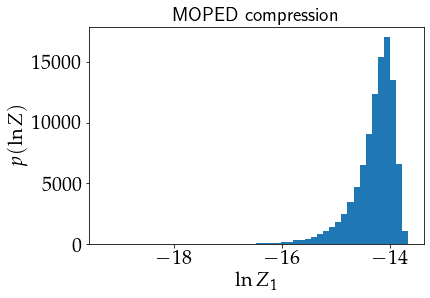

In [30]:
plt.hist(Z1_Y,bins=nbins, alpha=1, \
         range=[np.min(Z1_Y),np.max(Z1_Y)]);
plt.xlabel(r'$\ln Z_1$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'ZY1.pdf', bbox_inches='tight')

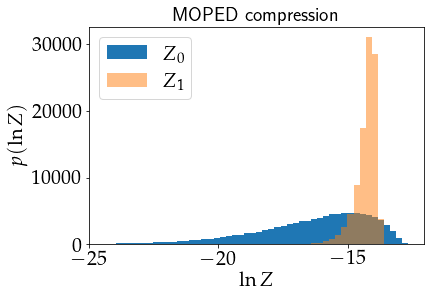

In [31]:
offset = 10.0
plt.hist(Z0_Y,bins=nbins, alpha=1, \
         range=[np.min([np.min(Z0_Y),np.min(Z1_Y)])+offset,np.max([np.max(Z0_Y),np.max(Z1_Y)])]);
plt.hist(Z1_Y,bins=nbins, alpha=0.5, \
         range=[np.min([np.min(Z0_Y),np.min(Z1_Y)])+offset,np.max([np.max(Z0_Y),np.max(Z1_Y)])]);
plt.xlabel(r'$\ln Z$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.legend([r'$Z_0$',r'$Z_1$'], fontsize=20)
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'ZY01.pdf', bbox_inches='tight')

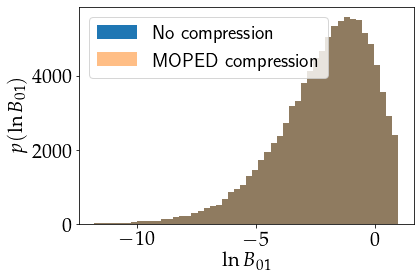

In [32]:
offset2 = 4
plotmin = np.min([np.min(Bayes_X),np.min(Bayes_Y)])+offset2
plotmax = np.max([np.max(Bayes_X),np.max(Bayes_Y)])

plt.hist(Bayes_X, alpha=1,bins=nbins, range=[plotmin,plotmax]);
plt.hist(Bayes_Y, alpha=0.5,bins=nbins, range=[plotmin,plotmax]);
plt.xlabel(r'$\ln B_{01}$', fontsize=20);
plt.ylabel(r'$p(\ln B_{01})$', fontsize=20);
plt.legend(['No compression','MOPED compression'], fontsize=20)
plt.savefig(fileroot+'BXY.pdf', bbox_inches='tight')

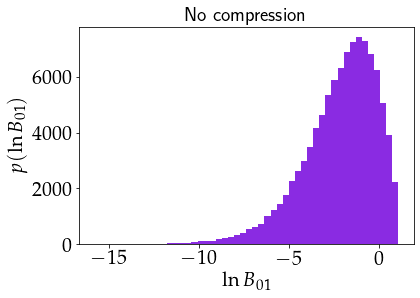

In [33]:
#plotExtend = np.min([np.min(Bayes_X)/np.max(Bayes_X),np.min(Bayes_Y)/np.max(Bayes_Y)])
plotExtend = 1.1

plotmax = np.max(Bayes_X)*plotExtend
plotmin = np.min(Bayes_X)

plt.hist(Bayes_X, alpha=1,bins=nbins, color='BlueViolet',range=[plotmin,plotmax]);
plt.xlabel(r'$\ln B_{01}$', fontsize=20);
plt.ylabel(r'$p(\ln B_{01})$', fontsize=20);
plt.title('No compression', fontsize=20)
plt.savefig(fileroot+'BX.pdf', bbox_inches='tight')

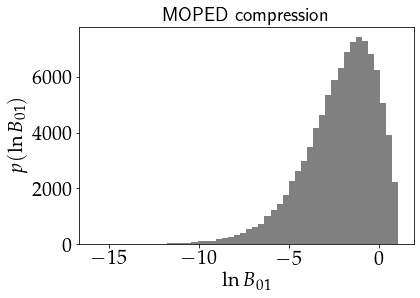

In [34]:
#plotmin = np.min(Bayes_Y)
plotmax = np.max(Bayes_Y)*plotExtend
plotmin = np.min(Bayes_Y)

plt.hist(Bayes_Y, alpha=1,bins=nbins, color='Gray',range=[plotmin,plotmax]);
plt.xlabel(r'$\ln B_{01}$', fontsize=20);
plt.ylabel(r'$p(\ln B_{01})$', fontsize=20);
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'BY.pdf', bbox_inches='tight')

In [35]:
FractionX0 = (Bayes_X > 0).sum()
FractionY0 = (Bayes_Y > 0).sum()

print('Fraction X0:', FractionX0)
print('Fraction Y0:', FractionY0)

Fraction X0: 12762
Fraction Y0: 12762
